# nuScenes Map Expansion Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from collections import defaultdict

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

In [2]:
nusc = NuScenes(version='v1.0-trainval', \
                dataroot='../../../../data/', \
                verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 28.8 seconds.
Reverse indexing ...
Done reverse indexing in 6.9 seconds.


In [3]:
so_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

# Extracting Trajectories

In [9]:
# dict with person token as key and other features as values
pedestrian_details = dict()

# dict with scene number as key and trajectories and map name as values
scene_info = dict()

# initializing a dict for layer names and number of points in each layer
layer_list = so_map.layer_names
layer_list.append("white_area")
layer_dict = dict.fromkeys(layer_list, 0)

# defining the sensor to extract ego_pose from sample_data, 
# we need a sensor to get sample_data
sensor = "LIDAR_TOP"

In [17]:
for n_scene in range(162,163): 
    # initialize the scene
    my_scene = nusc.scene[n_scene]
    # getting the map name
    cur_map = nusc.get('log', my_scene["log_token"])["location"]
    # entering the scene number and map name
    scene_info[str(n_scene)] = {"trajectories_x": [], "trajectories_y": [],\
                          "map_name": cur_map}

    # per scene person token database
    seen_person_tokens = []

    # first sample
    first_sample_token = my_scene['first_sample_token']
    sample = nusc.get('sample', first_sample_token)

    while True:
        for ann in sample['anns']:
            group_name = nusc.get('sample_annotation', ann)['category_name']
            if "human.pedestrian" in group_name and \
               nusc.get('sample_annotation', ann)['instance_token'] not in seen_person_tokens: 

                cur_person_token = nusc.get('sample_annotation', ann)['instance_token']
                cur_person_instance = nusc.get("instance", cur_person_token)
                nbr_samples = cur_person_instance['nbr_annotations']

                # initializing the dict with the new person token
                print("Person: ", cur_person_token)
                pedestrian_details[cur_person_token] = {"translation":[], 
                                                        "rotation":[],
                                                        "velocity":[],
                                                        "ego_translation":[],
                                                        "ego_rotation":[],
                                                        "ego_time": []}

                first_token = cur_person_instance['first_annotation_token']
                current_token = first_token

                for i in range(nbr_samples):
                    current_ann = nusc.get('sample_annotation', current_token)
                    
                    # getting the sample corresponding to this annotation to retrieve 
                    # ego details
                    annotation_sample = nusc.get('sample', current_ann['sample_token'])
                    
                    if current_ann["attribute_tokens"]:
                        current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']
                        if current_attr.split(".")[1] != "sitting_lying_down":
                            # updating pedestrian details dict
                            pedestrian_details[cur_person_token]["group"] = group_name.split(".")[-1]
                            pedestrian_details[cur_person_token]["translation"].append(
                                        current_ann["translation"])
                            pedestrian_details[cur_person_token]["rotation"].append(
                                        current_ann["rotation"])
                            pedestrian_details[cur_person_token]["scene_no"] = n_scene
                            pedestrian_details[cur_person_token]["map_name"] = cur_map
                            # only takes velocity at a particular time step
                            pedestrian_details[cur_person_token]["velocity"].append(
                                list(nusc.box_velocity(current_token)))
                            

                            # updating ego details
                            lidar_data = nusc.get('sample_data', 
                                                  annotation_sample['data'][sensor])
                            ego_token = lidar_data['ego_pose_token']
                            ego_pose = nusc.get('ego_pose', ego_token)
                            pedestrian_details[cur_person_token]["ego_translation"].append(
                                ego_pose["translation"])
                            pedestrian_details[cur_person_token]["ego_rotation"].append(
                                ego_pose["rotation"])
                            pedestrian_details[cur_person_token]["ego_time"].append(
                                ego_pose["timestamp"])
                                
                            layers_on_point_dict = map_files[cur_map].layers_on_point(
                                                           current_ann["translation"][0], 
                                                           current_ann["translation"][1])
                            
                            # calculate d_curb if he is on the walkway, give 0 otherwise
                            if layers_on_point_dict["walkway"]:
                                print("walkway")
                                records_patch = map_files[cur_map].get_records_in_patch(
                                     (current_ann["translation"][0]-25,
                                     current_ann["translation"][1]-25,
                                     current_ann["translation"][0]+25,
                                     current_ann["translation"][1]+25), 
                                     ["lane", "road_block", "road_segment"])
                                
                                polygons_consider = []
                                for l, pol in records_patch.items():
                                    for poli in pol:
                                        print(map_files[cur_map].get_bounds(l,poli))
                                        polygons_consider.append(
                                        tuple(map_files[cur_map].get_bounds(l,poli)))
                            else:
                                # set 0
                                print("on road")
                                
                                
                                
#                             # updating scene info dict
#                             scene_info[str(n_scene)]["trajectories_x"].append(
#                                         current_ann["translation"][0])
#                             scene_info[str(n_scene)]["trajectories_y"].append(
#                                         current_ann["translation"][1])
                            
#                             # updating layer dict
#                             cur_layers = map_files[cur_map].layers_on_point(
#                                 current_ann["translation"][0], current_ann["translation"][1])
#                             # if no layer has any tokens
#                             if all('' == s or s.isspace() for s in cur_layers.values()):
#                                 layer_dict["white_area"] += 1
#                             # if any layer has at least one token
#                             else:
#                                 for b, v in cur_layers.items():
#                                     if v:
#                                         layer_dict[b] += 1
                                        
                    current_token = current_ann["next"]


                seen_person_tokens.append(cur_person_token)

        if sample['next'] != '':
            sample = nusc.get('sample', sample['next'])
        else:
            #last sample of the scene
            break

Person:  4a56b45f7c214f76a8daea3c54bd2898
walkway
(1825.7060307890176, 1124.6344506607645, 1844.2834896959037, 1146.8544690622273)
(1804.272457960988, 1139.4149220160427, 1820.550218488618, 1150.5798672780438)
(1800.2995141805077, 1168.0041963942397, 1826.2902041045475, 1201.1383793489958)
(1802.2432937890528, 1142.7669840041801, 1816.6018801161306, 1156.2928774099141)
(1832.0025754925773, 1128.4794221225698, 1850.1985866383395, 1150.8221674748597)
(1789.8924423857388, 1162.6191654589886, 1817.1228616528388, 1193.6674471821652)
(1787.2002601298416, 1143.593254580082, 1800.5886085263655, 1154.7331289131491)
(1824.6725188803455, 1124.170173135413, 1844.2834896959037, 1146.8544690622273)
(1832.0025754925773, 1128.4794221225698, 1851.3568931374186, 1151.528498880403)
(1800.2995141805077, 1168.0041963942397, 1826.2902041045475, 1201.1383793489958)
(1787.2002601298416, 1143.593254580082, 1800.5886085263655, 1154.7331289131491)
(1804.272457960988, 1139.4149220160427, 1820.550218488618, 1150.5

walkway
(1825.7060307890176, 1124.6344506607645, 1844.2834896959037, 1146.8544690622273)
(1804.272457960988, 1139.4149220160427, 1820.550218488618, 1150.5798672780438)
(1800.2995141805077, 1168.0041963942397, 1826.2902041045475, 1201.1383793489958)
(1802.2432937890528, 1142.7669840041801, 1816.6018801161306, 1156.2928774099141)
(1832.0025754925773, 1128.4794221225698, 1850.1985866383395, 1150.8221674748597)
(1789.8924423857388, 1162.6191654589886, 1817.1228616528388, 1193.6674471821652)
(1824.6725188803455, 1124.170173135413, 1844.2834896959037, 1146.8544690622273)
(1832.0025754925773, 1128.4794221225698, 1851.3568931374186, 1151.528498880403)
(1800.2995141805077, 1168.0041963942397, 1826.2902041045475, 1201.1383793489958)
(1804.272457960988, 1139.4149220160427, 1820.550218488618, 1150.5798672780438)
(1789.8924423857388, 1162.6191654589886, 1817.1228616528388, 1193.6674471821652)
(1802.2432937890528, 1142.7669840041801, 1816.6018801161306, 1156.2928774099141)
(1802.2432937890528, 1139.

# Saving and Loading dictionaries

In [16]:
# SAVING all the dict files in details folder
with open('details/pedestrian_details.pkl', 'wb') as handle:
    pickle.dump(pedestrian_details, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('details/scene_info.pkl', 'wb') as handle:
    pickle.dump(scene_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('details/layer_dict.pkl', 'wb') as handle:
    pickle.dump(layer_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
new_ped_details = {}

# extracting the ped trajs with more than 16 samples
for k, v in pedestrian_details.items():
    if len(v['translation']) > 15:
        if not np.any(np.isnan(np.array(v['velocity']))):
            cur_diffs = [round(1e-6*(t-s),1) for s, t in zip(v['ego_time'], v['ego_time'][1:])]
            if not any(i > 0.9 for i in cur_diffs):
                new_ped_details[k] = v
        
# saving the new ped_details dict
with open('details/new_ped_details.pkl', 'wb') as handle:
    pickle.dump(new_ped_details, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# LOADING the necessary files
with open('details/scene_info.pkl', 'rb') as handle:
    scene_info = pickle.load(handle)
    
with open('details/pedestrian_details.pkl', 'rb') as handle:
    pedestrian_details = pickle.load(handle)
    
with open('details/new_ped_details.pkl', 'rb') as handle:
    new_ped_details = pickle.load(handle)

# Plotting

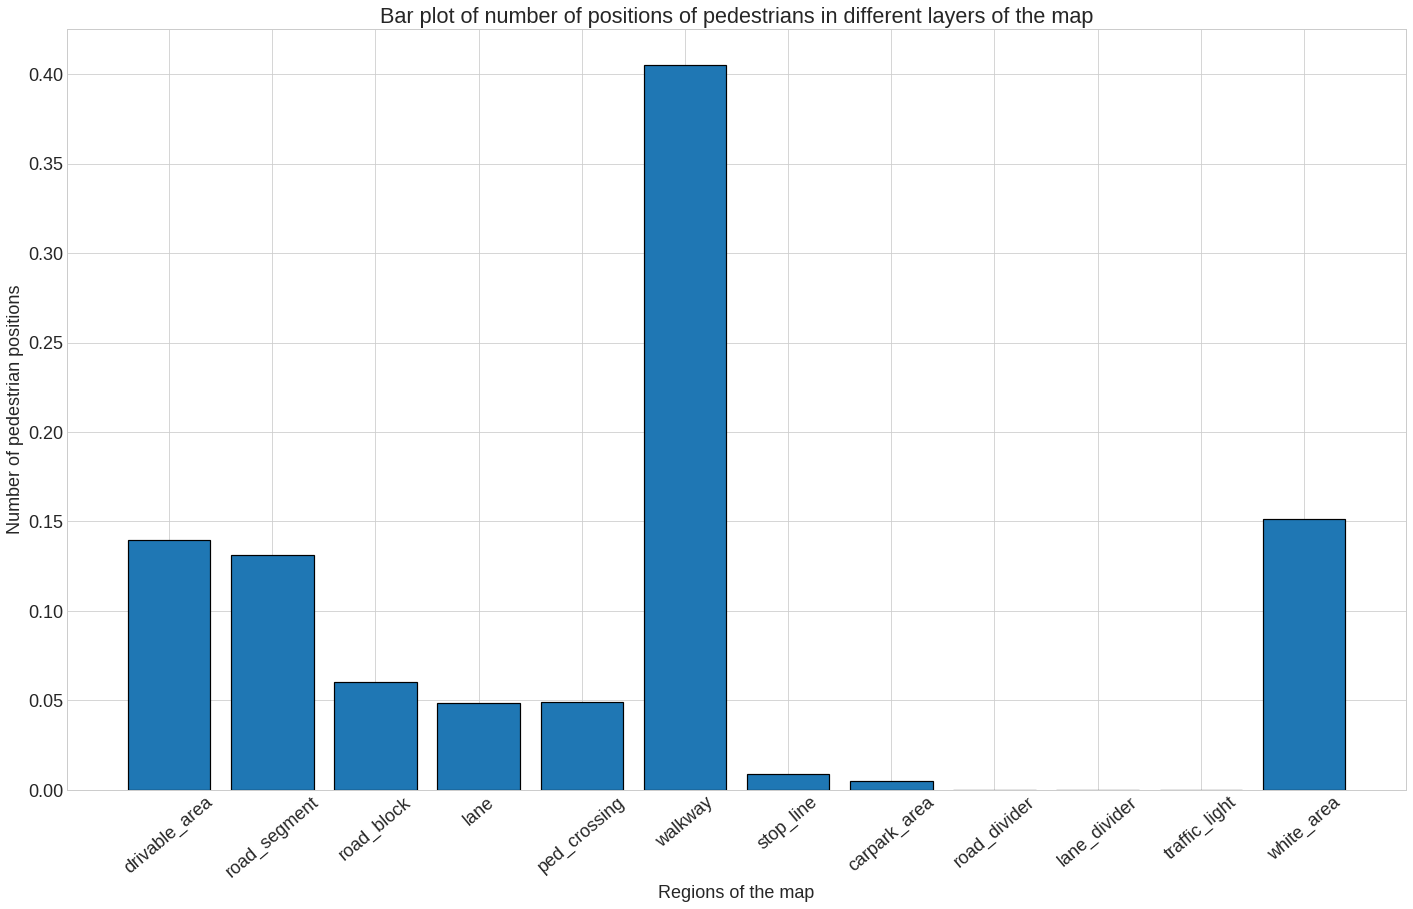

In [30]:
# Plotting the regions of pedestrian positions in all the scenes
plt.figure(figsize=(24,14))
plt.rcParams.update({'font.size': 18})
plt.bar(list(layer_dict.keys())[3:], layer_values[3:], align='center', edgecolor='black', linewidth=1.2)
plt.xlabel("Regions of the map")
plt.ylabel("Number of pedestrian positions")
plt.xticks(rotation=40)
plt.title("Bar plot of number of positions of pedestrians in different layers of the map")
plt.savefig("images/pedestrians_region.png", bbox_inches='tight', pad_inches=1)
plt.show()

In [4]:
# Plotting all the trajectories in every scene as an image over the map

#turning interactive plotting off
plt.ioff()

for n_scene in range(850):
    # plt.style.use('dark_background')
    ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(nusc, \
                    scene_tokens=[nusc.scene[n_scene]['token']], verbose=False)

    plt.scatter(scene_info[str(n_scene)]["trajectories_x"], 
                scene_info[str(n_scene)]["trajectories_y"], s=20, c='r', alpha=1.0, zorder=2)

    out_path = "images/scene_trajectories/" + str(n_scene) + "_trajectories.png"
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

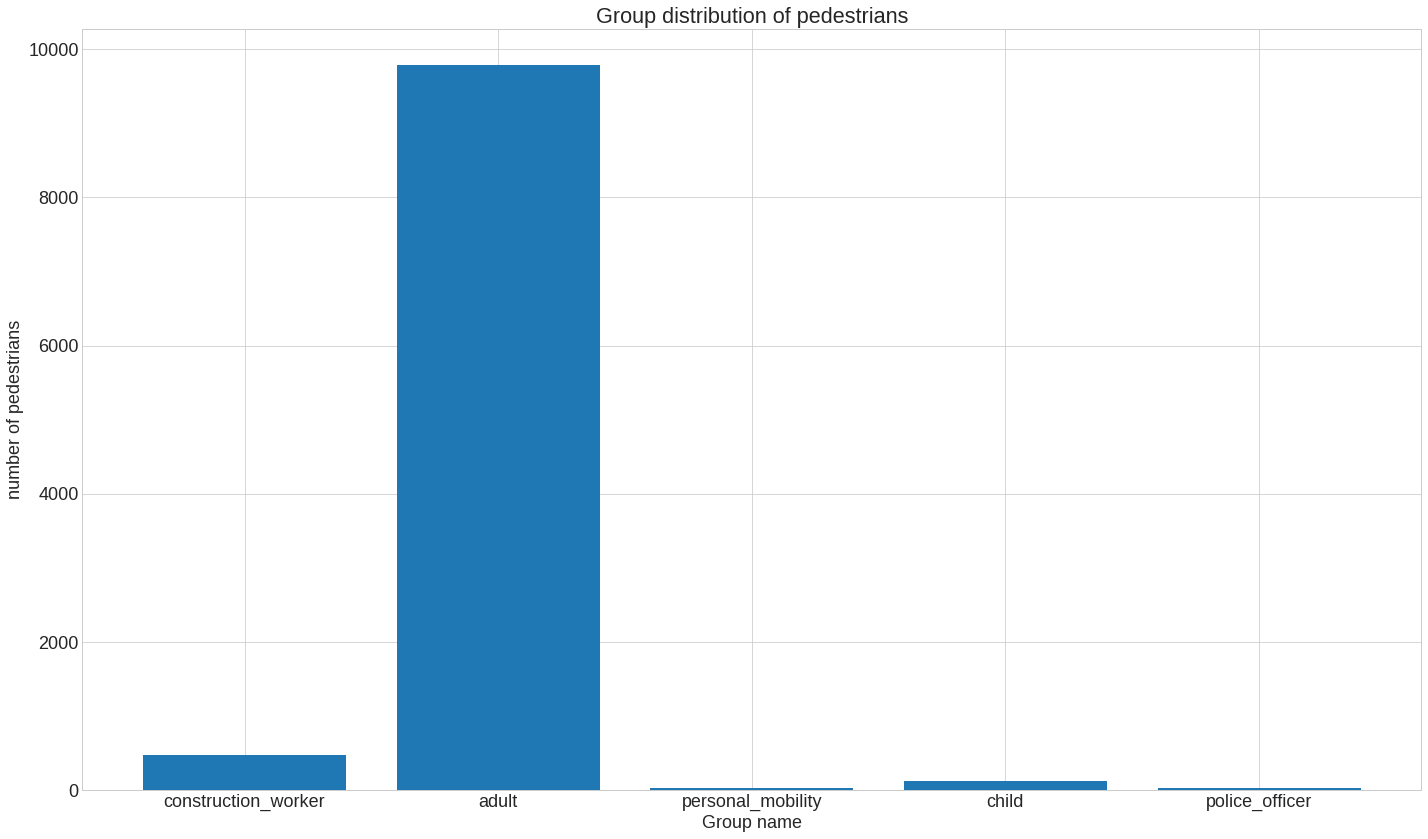

In [26]:
# Plotting the group name frequencies for pedestrians
group_count = defaultdict(int)

for p in pedestrian_details.keys():
    if "group" in pedestrian_details[p]:
        group_count[pedestrian_details[p]["group"]] += 1
    
plt.figure(figsize=(24,14))
plt.rcParams.update({'font.size': 18})
plt.bar(range(len(group_count)), list(group_count.values()), align='center')
plt.xticks(range(len(group_count)), list(group_count.keys()))
plt.xlabel("Group name")
plt.ylabel("number of pedestrians")
plt.title("Group distribution of pedestrians")
plt.savefig("images/pedestrians_group.png", bbox_inches='tight', pad_inches=1)
plt.show()

In [6]:
len_list = []
for k in new_ped_details.keys():
    len_list.append(len(new_ped_details[k]['translation']))
    
print("At least 16 points: ", sum(i >= 16 for i in len_list))

At least 16 points:  5659


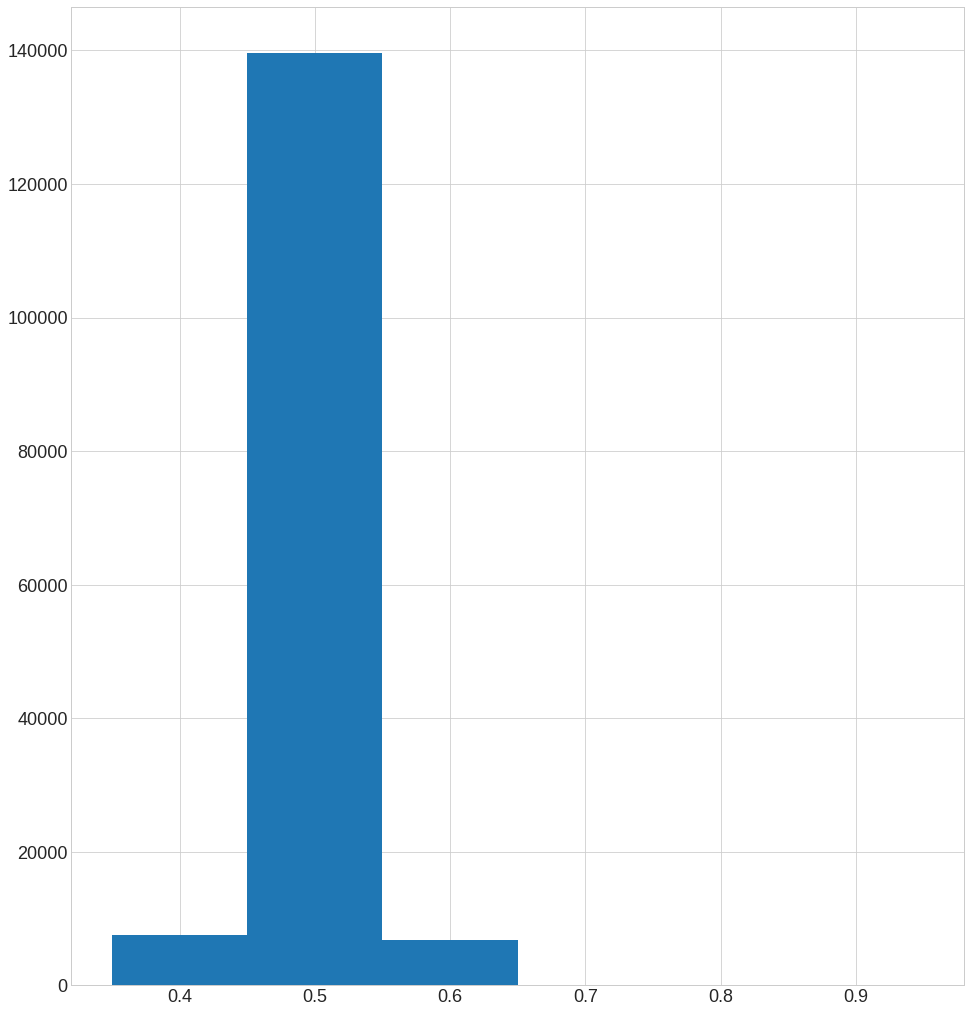

In [10]:
time_difs = []

for k, v in new_ped_details.items():
    time_difs += [round(1e-6*(t-s),1) for s, t in zip(v['ego_time'], v['ego_time'][1:])]
    
values, counts = np.unique(time_difs, return_counts=True)

plt.figure(figsize=(16,18))
plt.bar(values,counts, width=0.1)
plt.xticks(values)
plt.show()

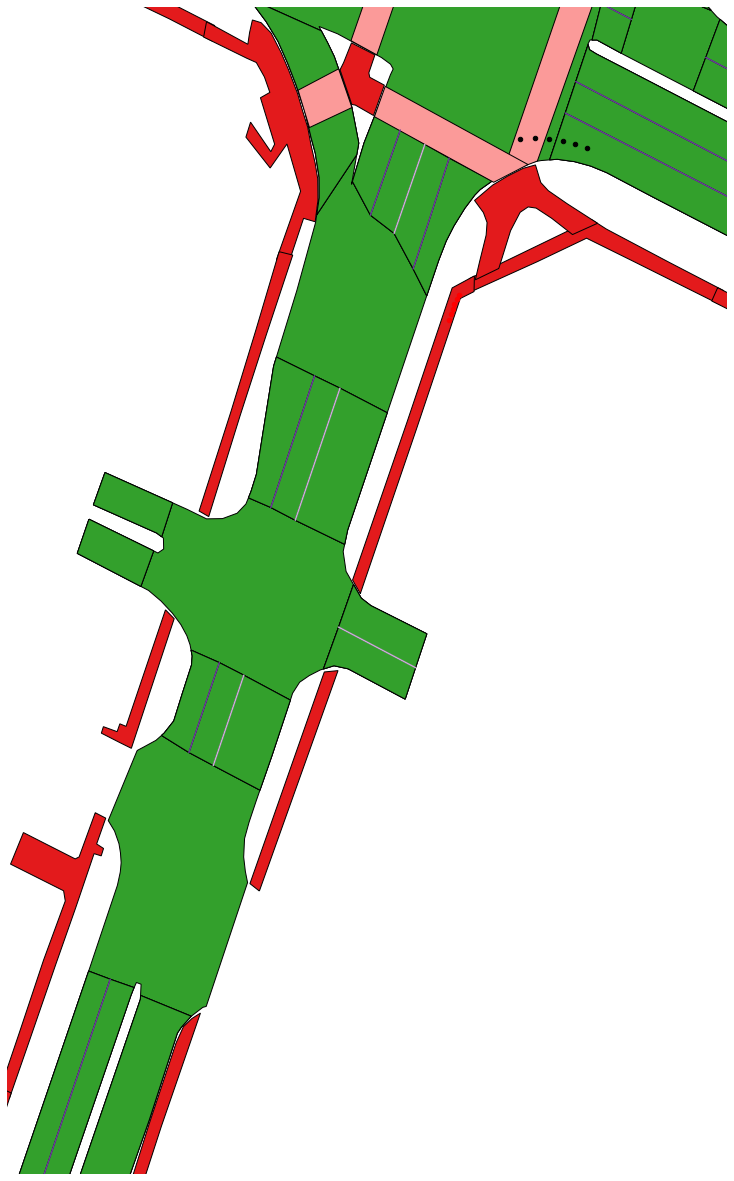

In [5]:
pedestrian_key = list(new_ped_details.keys())[5]
ped_scene = new_ped_details[pedestrian_key]['scene_no']
ego_poses = map_files[scene_info[str(ped_scene)]["map_name"]].render_egoposes_on_fancy_map(nusc, \
                scene_tokens=[nusc.scene[ped_scene]['token']], verbose=False,
                render_egoposes=False, render_egoposes_range=False, 
                render_legend=False)
plt.scatter(np.array(new_ped_details[pedestrian_key]['ego_translation'])[:6,0], 
            np.array(new_ped_details[pedestrian_key]['ego_translation'])[:6,1], s=20, c='k', alpha=1.0, zorder=2)
plt.scatter(np.array(new_ped_details[pedestrian_key]["translation"])[:6,0], 
            np.array(new_ped_details[pedestrian_key]["translation"])[:6,1], s=20, c='r', alpha=1.0, zorder=2)
plt.show()

In [12]:
for n_scene in range(6,7):
    ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
                    nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
                    render_egoposes=True, render_egoposes_range=False, 
                    render_legend=True)

    plt.scatter(scene_info[str(n_scene)]["trajectories_x"], 
                scene_info[str(n_scene)]["trajectories_y"], s=20, c='r', alpha=1.0, zorder=2)

    out_path = "images/" + "new" + "_trajectories1.png"
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Distance analysis

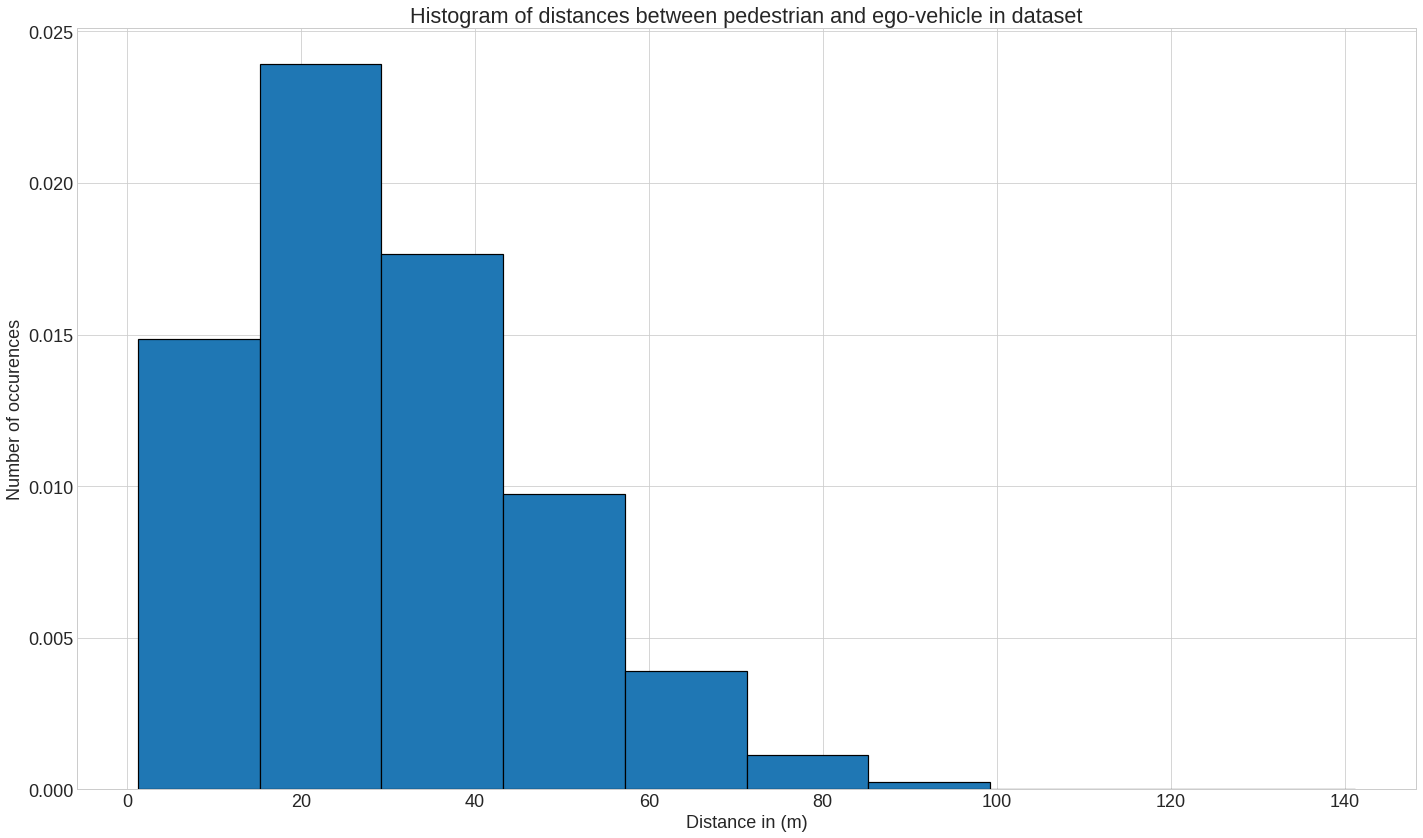

In [15]:
def calculate_dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

dist_list = []

for ped_key in new_ped_details.keys():
    for p, v in zip(new_ped_details[ped_key]["translation"], 
                    new_ped_details[ped_key]["ego_translation"]):
        dist_list.append(calculate_dist(p[:2], v[:2]))
        
plt.figure(figsize=(24,14))
plt.rcParams.update({'font.size': 18})
plt.hist(dist_list, bins=10, density=True, align="mid", edgecolor='black', linewidth=1.2)
plt.xlabel("Distance in (m)")
plt.ylabel("Number of occurences")
plt.title("Histogram of distances between pedestrian and ego-vehicle in dataset")
plt.savefig("images/pedestrians_distance.png", bbox_inches='tight', pad_inches=1)
plt.show()   

In [47]:
velocities = velocities[~np.isnan(velocities).any(axis=1)]
velocities = velocities[~np.all(velocities == 0, axis=1)]

In [50]:
velocities = np.absolute(velocities)

In [52]:
vel_x, vel_y, vel_z = np.mean(velocities, axis=0)

In [53]:
print("Average velocity in x direction ", vel_x)
print("Average velocity in y direction ", vel_y)
print("Average velocity in z direction ", vel_z)

Average velocity in x direction  0.17261973533096817
Average velocity in y direction  0.39918449907538506
Average velocity in z direction  0.240335396440526
